In [1]:
import skimage as ski
import skimage.morphology as mp
from skimage import io, feature,filters
from skimage import img_as_float
from skimage.color import rgb2hsv,rgb2gray,hsv2rgb
from skimage.filters.edges import convolve
from skimage.morphology import disk
import warnings
from matplotlib import pylab as plt
warnings.simplefilter("ignore")
import os
from skimage.morphology import flood_fill
import numpy as np
import random
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import KFold
from torchvision.transforms import ToTensor

In [43]:
def readFile(path):
    img=io.imread(path)
    return img
def convert2gray(img):
    return(img_as_float(rgb2gray(img)))
def preProcess(img):
    img=convert2gray(img)
    img=filters.gaussian(img,sigma=5) 
    img=img**0.4
    return img
def process(img):
    img=filters.sobel(img)
    MIN = np.min(img)
    MAX = np.max(img)
    img = (img - MIN) / (MAX - MIN)
    img[img[:,:] > 1] = 1
    img[img[:,:] < 0] = 0
    img=img*(img>np.percentile(img,80))
    img=(img>0)*1.0

    return img
def postProcess(img,mask):
    img=mp.dilation(img,selem=disk(10))
    img=mp.erosion(img,selem=disk(15))
    mask=convert2gray(mask)
    for i in range(20):
        mask=mp.erosion(mask)
    img=img*mask

    return img
def createResult(base,img):
    for b,i in zip(base,img):
        for c,j in zip(b,i):
            if j==1:
                c[0]=255
                c[1]=255
                c[2]=255

    return base
def wholeProcess(base,mask):
    img=preProcess(base)
    img=process(img)
    img=postProcess(img,mask)
    base=createResult(base,img)
    return base, img
def getFileNames(path):
    return os.listdir(path)
def takeFewExamples(amount):
    images=getFileNames(os.getcwd()+"\\images")
    chosenImages=random.sample(images,amount)
    names=[]
    imagesPaths=[]
    masksPaths=[]
    manualPaths=[]
    for i in chosenImages:
        names.append(i[:-4])
    for i in names:
        imagesPaths.append(os.getcwd()+"\\images\\"+i+".jpg")
        masksPaths.append(os.getcwd()+"\\mask\\"+i+"_mask.tif")
        manualPaths.append(os.getcwd()+"\\manual1\\"+i+".tif")
    return imagesPaths, masksPaths, manualPaths
def takeAll():
    images=getFileNames(os.getcwd()+"\\images")
    names=[]
    imagesPaths=[]
    masksPaths=[]
    manualPaths=[]
    for i in images:
        names.append(i[:-4])
    for i in names:
        imagesPaths.append(os.getcwd()+"\\images\\"+i+".jpg")
        masksPaths.append(os.getcwd()+"\\mask\\"+i+"_mask.tif")
        manualPaths.append(os.getcwd()+"\\manual1\\"+i+".tif")
    return imagesPaths, masksPaths, manualPaths
def showImages(images):
    for i in range(1,len(images)+1):
        showImg(images[i-1])

def showImg(img):
    fig=plt.figure(figsize=(20,10))
    plt.imshow(img)
def countStatistics(image, manual1,masks):
    total=0
    TP=0
    FP=0
    FN=0
    TN=0
    for img,man,mask in zip(image,manual1,masks):
        for i,j,k in zip(img,man,mask):
           
            if k==1:
                if j==i==0:
                    TN+=1
                if j==i==1:
                    TP+=1
                if i==0 and j==1:
                    FN+=1
                if i==1 and j==0:
                    FP+=1
                total+=1
    accuracy=(TP+TN)/total
    sensitivity=TP/(TP+FN)
    precision=TP/(FP+TP)
    specificity=TN/(FP+TN)
    return accuracy,sensitivity,precision,specificity
def printStatistics(tup):
    print("Accuracy: "+str(tup[0]))
    print("Sensitivity: "+str(tup[1]))
    print("Precision: "+str(tup[2]))
    print("Specificity: "+str(tup[3]))
    print("Mean of sensitivity and specificity: "+str((tup[1]+tup[3])/2))
                    
def divideImg(size=18,amount=1000):   #returns data and target in lists
    imagesPaths,masksPaths,manualPaths=takeAll()
    half=size//2
    transform=ToTensor()
    allPositive=[]
    allNegative=[]
    for image,maskP,manualP in zip(imagesPaths,masksPaths,manualPaths):
        img=img_as_float(readFile(image))

        mask=convert2gray(readFile(maskP))
        manual=convert2gray(readFile(manualP))
        positive=[]
        negative=[]
        while (len(positive)<int(amount*0.5)) or (len(negative)<int(amount*0.5)):
            x=random.randint(half,len(img)-size+half)
            y=random.randint(half,len(img[0])-size+half)
            if mask[x][y]==1:
                if manual[x][y]==1:
                    if len(positive)<int(amount*0.5):

                        positive.append(img[x-half:x+size-half,y-half:y+size-half])
                else:
                    if len(negative)<int(amount*0.5):
                        negative.append(img[x-half:x+size-half,y-half:y+size-half])
        allPositive+=positive
        allNegative+=negative
        labels=np.ones(len(allPositive)+len(allNegative))
        labels[len(allPositive):]=0
        allImgs=allPositive+allNegative
    return allImgs,labels

def prepareDataset(x,y):
    kfold=KFold(5,True,1)
    data=TensorDataset(torch.Tensor(x).permute(0, 3, 1, 2),torch.Tensor(y))    #permute for changing from NHWC to NCHW
    return kfold,data
def prepareLoaders(trainData,testData,batchSize):
    trainLoader=DataLoader(dataset=trainData,batch_size=batchSize,shuffle=True)
    testLoader=DataLoader(dataset=testData,batch_size=len(testData))
    return trainLoader,testLoader
def prepareModel():
    layers=[]
    layers.append(nn.Conv2d(3,30,3,stride=1,padding=1))
    layers.append(nn.LeakyReLU())
    layers.append(nn.Conv2d(30,30,3,stride=1,padding=1))
    layers.append(nn.LeakyReLU())
    layers.append(nn.MaxPool2d(2))
   
    layers.append(nn.Conv2d(30,60,3,stride=1,padding=1))
    layers.append(nn.LeakyReLU())
    layers.append(nn.Conv2d(60,60,3,stride=1,padding=1))
    layers.append(nn.LeakyReLU())
    layers.append(nn.Flatten())
    layers.append(nn.Linear(60*9*9,60))
    layers.append(nn.LeakyReLU())
    layers.append(nn.Linear(60,2))
    model=nn.Sequential(*layers)
    cost=torch.nn.CrossEntropyLoss()
    opt=optim.Adam(model.parameters())
    return model,cost,opt
    
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()
def train(kfold,data):
    max_epoch = 10000
    no_improvement = 5
    batchSize=500
    models=[]
    accs=[]
    for i in range(5):   #k-fold-cross-validation
        print(str(i+1)+". iteration of cross validation")
        model,cost,opt=prepareModel()
        sets=next(kfold.split(data),None)
        trainLoader,testLoader=prepareLoaders(TensorDataset(data[sets[0]][0],data[sets[0]][1]),
                                              TensorDataset(data[sets[1]][0],data[sets[1]][1]),
                                               batchSize)
        train_loss = []
        validation_acc = []
        best_model = None
        best_acc = None
        best_epoch = None


        for n_epoch in range(max_epoch):
            model.train()
            epoch_loss = []
            for X_batch, y_batch in trainLoader:
                opt.zero_grad()
                logits = model(X_batch)
                loss = cost(logits, y_batch.long())
                loss.backward()
                opt.step()        
                epoch_loss.append(loss.detach())
            train_loss.append(torch.tensor(epoch_loss).mean())
            model.eval()
            X, y = next(iter(testLoader))
            logits = model(X)
            acc = compute_acc(logits, y).detach()
            validation_acc.append(acc)
            if best_acc is None or acc > best_acc:
                print("New best epoch ", n_epoch, "acc", acc)
                best_acc = acc
                best_model = model.state_dict()
                best_epoch = n_epoch
            if best_epoch + no_improvement <= n_epoch:
                print("No improvement for", no_improvement, "epochs")
                break
        
        model.load_state_dict(best_model)
        models.append(best_model)
        accs.append(best_acc)
        del model
        del opt
        del cost
    return accs,models
def chooseBestModel(models,accs):
    model,cost,opt=prepareModel()
    model.load_state_dict(models[accs.index(max(accs))])
    return model
def checkModel(model,numOfExamples=1,size=18):
    model.eval()
    half=size//2
    imagesPaths,masksPaths,manualPaths=takeFewExamples(numOfExamples)
    print(imagesPaths)
    for image,maskP,manualP in zip(imagesPaths,masksPaths,manualPaths):
       
        b=readFile(image)
        newImg=np.zeros((len(b),len(b[0])))
        mask=convert2gray(readFile(maskP))
        manual=convert2gray(readFile(manualP))
        base=b.copy()
        modelResult=base.copy()
        for i in range(half+1000,1200-size+half):
            tmp=[]
            for j in range(half+1000, 1200-size+half):
                 if mask[i][j]==1:
                    tmp.append(b[i-half:i+size-half,j-half:j+size-half])
            logits=model(torch.Tensor(tmp).permute(0, 3, 1, 2))
            binY=logits.argmax(dim=1)
            for j in range(half+1000, 1200-size+half):
                 if mask[i][j]==1:
                    for k in range(len(binY)):
                        if binY[k]==1:
                            modelResult[i][k+j][0]=255
                            modelResult[i][k+j][1]=255
                            modelResult[i][k+j][2]=255
                            newImg[i][k+j]=1
                    break
        tup=countStatistics(newImg,manual,mask)
        printStatistics(tup)
        showImages([img_as_float(newImg),modelResult,b])

In [32]:
def normalMethod(numOfExamples=1):
    imagesPaths,masksPaths,manualPaths=takeFewExamples(numOfExamples)
    for image,maskP,manualP in zip(imagesPaths,masksPaths,manualPaths):
        base=readFile(image)
        mask=readFile(maskP)
        manual=readFile(manualP)
        newBase,res=wholeProcess(base.copy(),mask.copy())
        showImages([base,newBase,res])
        printStatistics(countStatistics(res,convert2gray(manual),convert2gray(mask)))


    

Accuracy: 0.9303375093756623
Sensitivity: 0.7219435064281796
Precision: 0.5316284953488535
Specificity: 0.9475291668180389


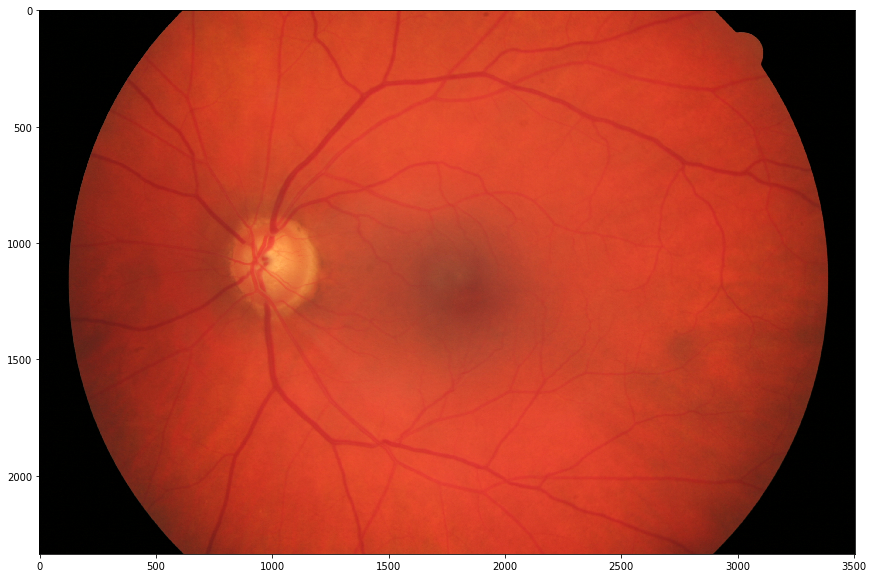

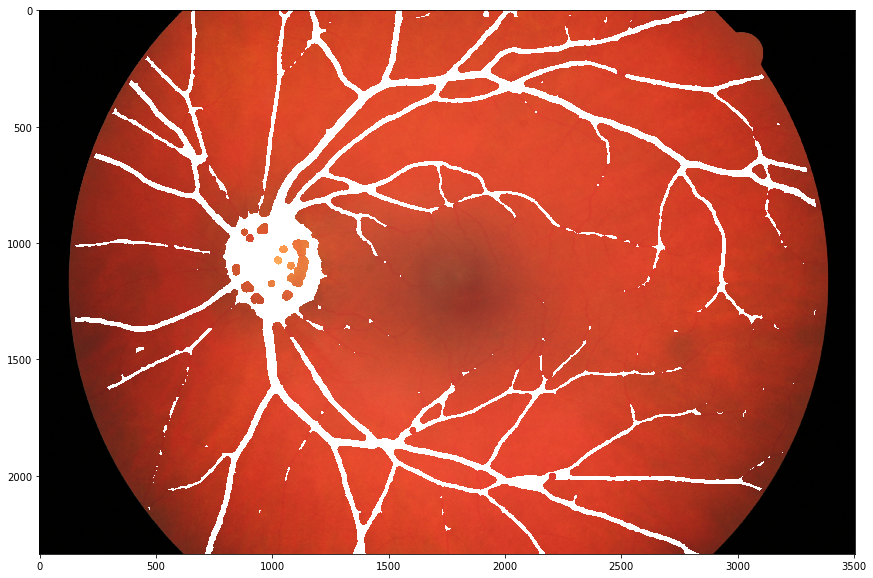

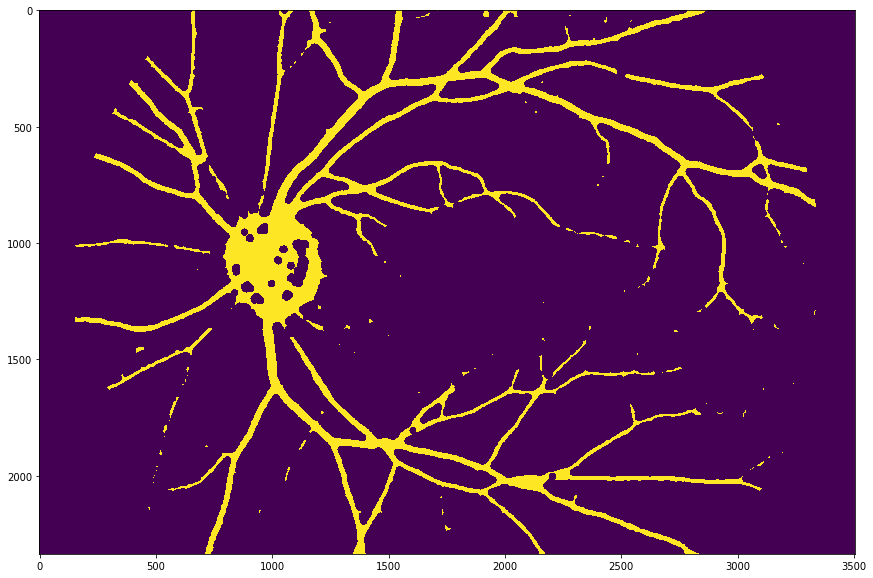

In [4]:
normalMethod()

In [33]:
allImgs,labels=divideImg()
kfold,data=prepareDataset(allImgs,labels)

In [36]:
accs,models=train(kfold,data)

1. iteration of cross validation
New best epoch  0 acc tensor(0.8114)
New best epoch  1 acc tensor(0.8301)
New best epoch  2 acc tensor(0.8538)
New best epoch  4 acc tensor(0.8754)
New best epoch  6 acc tensor(0.8839)
New best epoch  8 acc tensor(0.8859)
New best epoch  10 acc tensor(0.8931)
New best epoch  11 acc tensor(0.8933)
New best epoch  12 acc tensor(0.8960)
New best epoch  13 acc tensor(0.8968)
New best epoch  14 acc tensor(0.9010)
New best epoch  15 acc tensor(0.9046)
No improvement for 5 epochs
2. iteration of cross validation
New best epoch  0 acc tensor(0.7161)
New best epoch  1 acc tensor(0.8398)
New best epoch  2 acc tensor(0.8433)
New best epoch  3 acc tensor(0.8610)
New best epoch  4 acc tensor(0.8627)
New best epoch  5 acc tensor(0.8703)
New best epoch  6 acc tensor(0.8778)
New best epoch  7 acc tensor(0.8788)
New best epoch  8 acc tensor(0.8872)
New best epoch  9 acc tensor(0.8874)
New best epoch  10 acc tensor(0.8912)
New best epoch  11 acc tensor(0.8946)
New best e

In [37]:
model=chooseBestModel(models,accs)

In [45]:
torch.save(model.state_dict(),"savedModel.pt") #for possibility of losing trained model

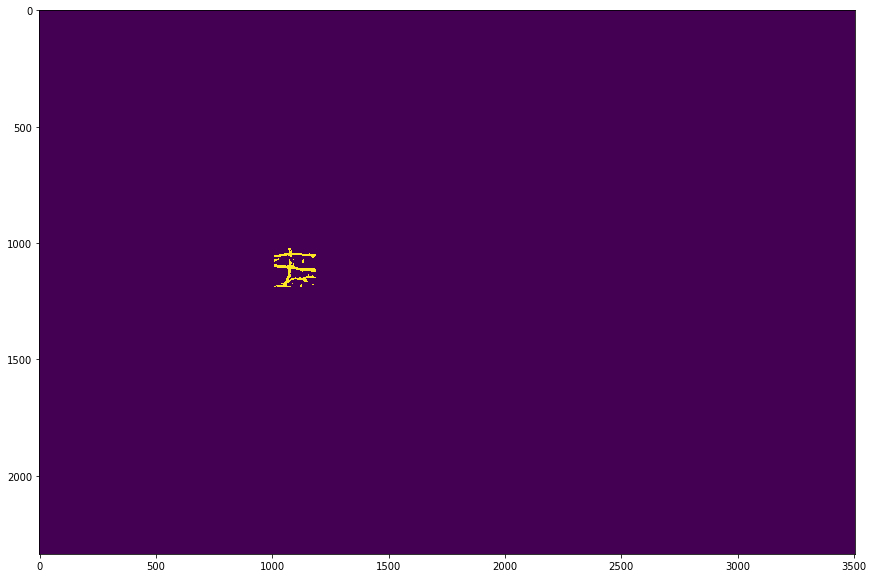

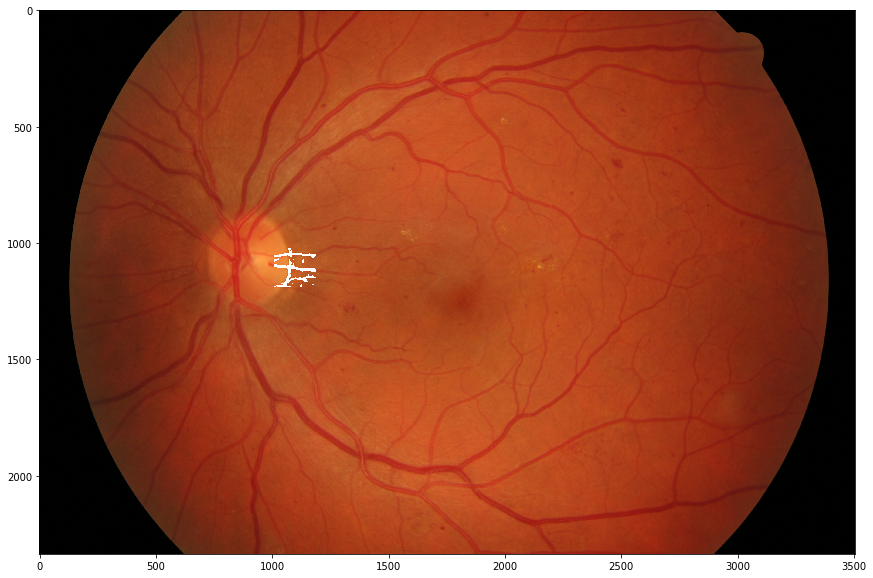

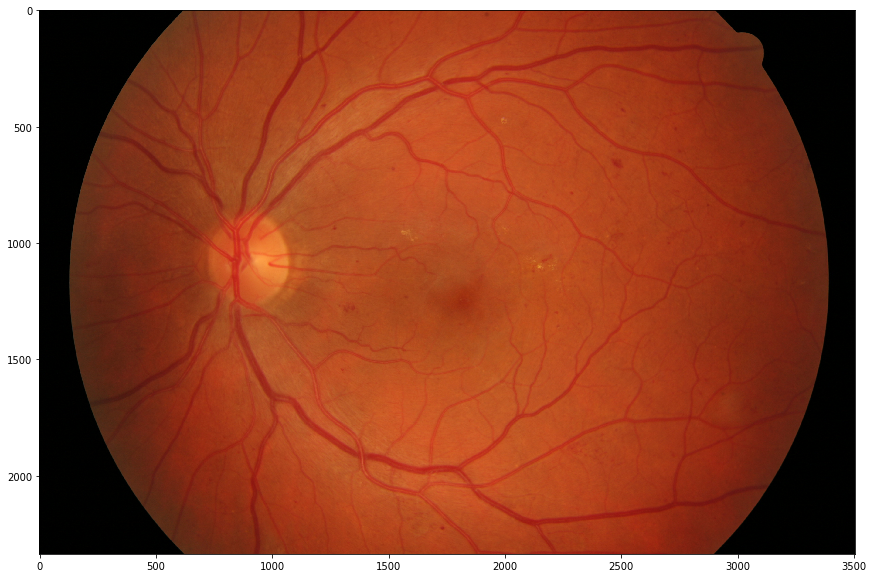

In [42]:
checkModel(model)

True
